In [1]:
import xarray as xr

raster_resolution = 500

GEBCO = xr.open_dataset(
    "https://dap.ceda.ac.uk/thredds/dodsC/bodc/gebco/global/gebco_2025/ice_surface_elevation/netcdf/GEBCO_2025.nc"
)

bbox = {"lon_min": 31.0, "lon_max": 35.0, "lat_min": 30.3, "lat_max": 33.0}

GEBCO_sel = GEBCO.sel(
    lon=slice(bbox["lon_min"], bbox["lon_max"]),
    lat=slice(bbox["lat_min"], bbox["lat_max"]),
)

GEBCO_sel

<xarray.Dataset> Size: 1MB
Dimensions:    (lat: 648, lon: 960)
Coordinates:
  * lat        (lat) float64 5kB 30.3 30.31 30.31 30.31 ... 32.99 32.99 33.0
  * lon        (lon) float64 8kB 31.0 31.01 31.01 31.01 ... 34.99 34.99 35.0
Data variables:
    crs        |S64 64B ...
    elevation  (lat, lon) int16 1MB ...
Attributes: (12/37)
    title:                           The GEBCO_2025 Grid - a continuous terra...
    summary:                         The GEBCO_2025 Grid is a continuous, glo...
    keywords:                        BATHYMETRY/SEAFLOOR TOPOGRAPHY, DIGITAL ...
    Conventions:                     CF-1.6, ACDD-1.3
    id:                              DOI: 10.5285/37c52e96-24ea-67ce-e063-708...
    naming_authority:                https://dx.doi.org
    ...                              ...
    geospatial_vertical_resolution:  1.0
    geospatial_vertical_positive:    up
    identifier_product_doi:          DOI: 10.5285/37c52e96-24ea-67ce-e063-708...
    references:                      DOI: 10.5285/37c52e96-24ea-67ce-e063-708...
    node_offset:                     1.0
    DODS.strlen:                     0

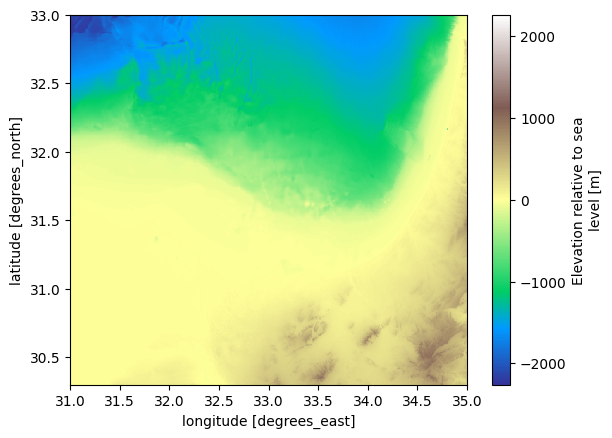

In [2]:
GEBCO_sel["elevation"].plot(cmap="terrain");

In [3]:
import pyproj

crs_var = GEBCO_sel["crs"]
epsg = crs_var.attrs.get("epsg_code", None)
code = int(epsg.split(":")[-1])
crs = pyproj.CRS.from_epsg(code)

In [4]:
from pymesh2d.geom_util.getiso import getiso_polygone

lon = GEBCO_sel["lon"]
lat = GEBCO_sel["lat"]
zdat = GEBCO_sel["elevation"]

polygone_intersection = getiso_polygone(lon, lat, zdat, zmax=0.0)

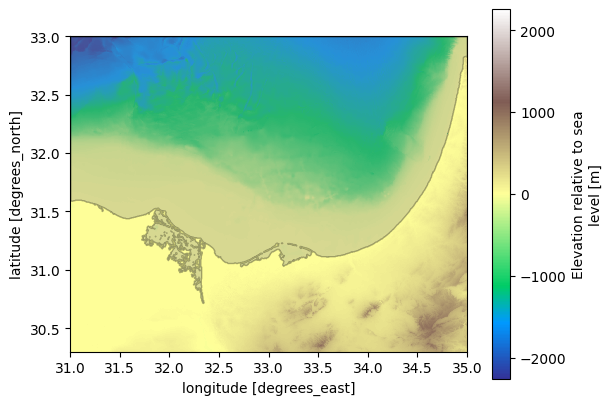

In [5]:
import geopandas as gpd

raster = GEBCO_sel["elevation"].plot(cmap="terrain")
ax = raster.axes
gdf = gpd.GeoDataFrame(geometry=[polygone_intersection], crs=crs)
gdf.plot(ax=ax, facecolor="grey", alpha=0.3, edgecolor="black");


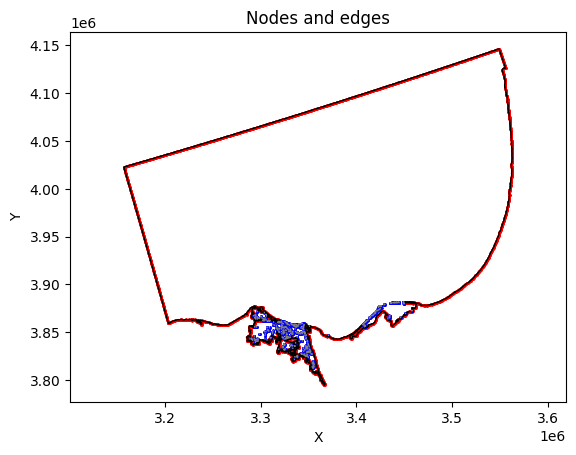

In [6]:
import matplotlib.pyplot as plt

from pymesh2d.geom_util.poly_util import resample_polygon
from pymesh2d.geom_util.proj_util import get_utm_crs_from_crs, reproject_geometry

polygone_intersection_UTM = reproject_geometry(
    polygone_intersection, crs, get_utm_crs_from_crs(crs)
)

polygone_intersection_resampled_UTM = resample_polygon(
    polygone_intersection_UTM, raster_resolution
)

x, y = polygone_intersection_resampled_UTM.exterior.xy
plt.scatter(x, y, color="red", s=1, label="Exterior points")
plt.plot(x, y, color="black", lw=1)

for hole in polygone_intersection_resampled_UTM.interiors:
    xh, yh = hole.xy
    plt.scatter(xh, yh, color="blue", s=1, label="Hole poin ts")
    plt.plot(xh, yh, color="gray", linestyle="--", lw=1)

plt.xlabel("X")
plt.ylabel("Y")
plt.title("Nodes and edges")
plt.axis("equal");

In [7]:
from shapely.geometry import Polygon

from pymesh2d.geom_util.poly_util import buffer_area_for_polygon

poly_bbox = Polygon(
    [
        (bbox["lon_min"], bbox["lat_min"]),
        (bbox["lon_min"], bbox["lat_max"]),
        (bbox["lon_max"], bbox["lat_max"]),
        (bbox["lon_max"], bbox["lat_min"]),
        (bbox["lon_min"], bbox["lat_min"]),
    ]
)

poly_bbox_UTM = reproject_geometry(poly_bbox, crs, get_utm_crs_from_crs(crs))

poly_bbox_UTM = buffer_area_for_polygon(poly_bbox_UTM, -0.05)


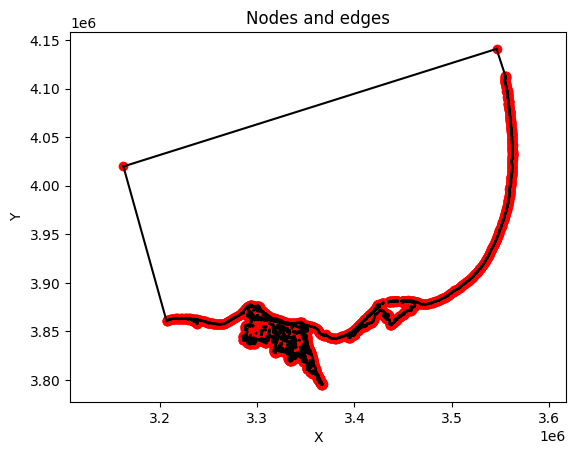

In [8]:
import matplotlib.pyplot as plt

from pymesh2d.geom_util.poly_util import polygon_to_node_edge

polygone_final_UTM = polygone_intersection_resampled_UTM.intersection(poly_bbox_UTM)
node, edge = polygon_to_node_edge(polygone_final_UTM)

for e in edge.astype(int):
    plt.plot(node[e, 0], node[e, 1], "k-")
plt.scatter(node[:, 0], node[:, 1], color="red")

plt.xlabel("X")
plt.ylabel("Y")
plt.title("Nodes and edges")
plt.axis("equal");

In [9]:
from pymesh2d.geomesh_util.depth_field import depth_field_from_xr
from pymesh2d.geomesh_util.hfun_dispercion import hfun_wavenumhunt

depth_field = depth_field_from_xr(
    GEBCO_sel, input_crs=crs, output_crs=get_utm_crs_from_crs(crs), var_name="elevation"
)


def hfun(test):
    return hfun_wavenumhunt(
        test, depth_field, T=60 * 60 * 3, N=10, zmin=1, hmin=raster_resolution
    )


In [10]:
from pymesh2d.refine import refine
from pymesh2d.smooth import smooth

opts_refine = {"kind": "delaunay"}

vert, etri, tria, tnum = refine(node, edge, [], opts_refine, hfun)

opts_smooth = {"removesmalllinkstrsh": 0.11}

vert, etri, tria, tnum = smooth(vert, etri, tria, tnum, opts_smooth)


 Refine triangulation...

 -------------------------------------------------------
      |ITER.|          |CDT1(X)|          |CDT2(X)|     
 -------------------------------------------------------
          8               4439               4551
         10               4441               5337
         20               4508              17020
         30               4524              31614
         40               4525              33407
         43               4525              33415


 Smooth triangulation...

 -------------------------------------------------------
      |ITER.|          |MOVE(X)|          |DTRI(X)|     
 -------------------------------------------------------
          0              13878              32829
          4              10960              32320
          8               4192              32312
         12                414              32308
         16                 39              32308
         20                 14              32308
   

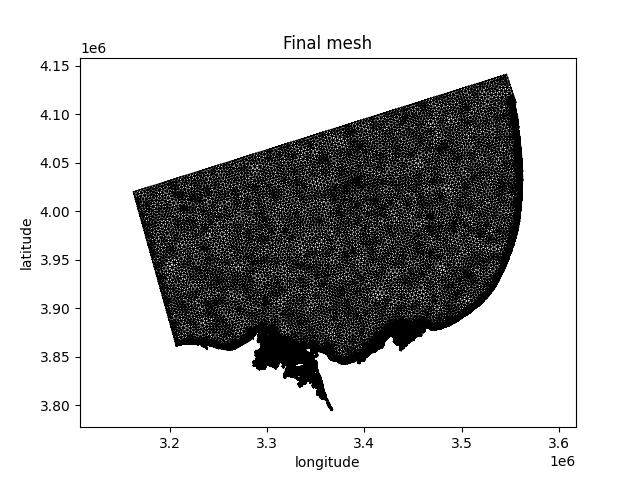


    0 small flow links discarded


In [11]:
from pymesh2d.mesh_util.tricon import tricon
from pymesh2d.mesh_util.circo import small_flow_centers


edge, _ = tricon(tria, None)  # None si pas de contraintes

# Obtenir les circumcenters des triangles problématiques
circumcenters, nlinktoosmall = small_flow_centers(
    vert, tria, edge, removesmalllinkstrsh=0.11, conn=None
)
%matplotlib widget
fig, ax = plt.subplots()
ax.triplot(vert[:, 0], vert[:, 1], tria[:, 0:3], color="k", lw=0.8)
ax.scatter(circumcenters[:, 0], circumcenters[:, 1], 
            color="red", s=20, alpha=0.7)
    
plt.xlabel("longitude")
plt.ylabel("latitude")
plt.title("Final mesh")
plt.axis("equal");
plt.show()

print(f"\n{nlinktoosmall:5d} small flow links discarded")

In [12]:
from pymesh2d.geom_util.proj_util import reproject_node

vert = reproject_node(vert, get_utm_crs_from_crs(crs), crs)

plt.triplot(vert[:, 0], vert[:, 1], tria[:, 0:3], color="k", lw=0.8)
plt.xlabel("longitude")
plt.ylabel("latitude")
plt.title("Final mesh")
plt.axis("equal");

In [13]:
from pymesh2d.geomesh_util.interpolation_mesh import interpolate_from_xr

z = interpolate_from_xr(GEBCO_sel, vert, var_name="elevation")

In [14]:
import numpy as np

from pymesh2d.geomesh_util.grd_util import adcirc2DFlowFM

adcirc2DFlowFM(np.column_stack((vert, z)), tria, "GEBCO_grid.nc")

In [15]:
from pymesh2d.geomesh_util.border_util import identify_boundary

edge_tag, edge_open, edge_land = identify_boundary(vert, tria, z, zlim=15)

In [16]:
from pymesh2d.geomesh_util.grd_util import export_to_grd

export_to_grd(
    "GEBCO_grid.grd",
    vert=vert,
    tria=tria,
    z=z,
    crs=crs,
    edge_tag=edge_tag,
    edge_open=edge_open,
    edge_land=edge_land,
)

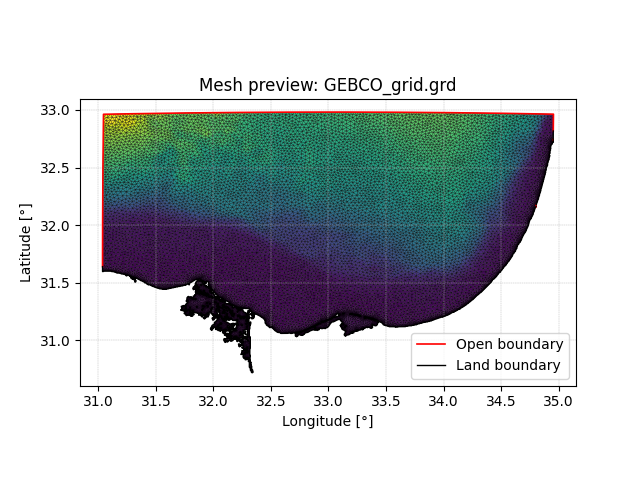

In [17]:
from pymesh2d.geomesh_util.grd_util import plot_grd

plot_grd("GEBCO_grid.grd", show_boundaries=True)